In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import json
import os
import boto3
import yaml
from PIL import Image
from utils.misc import decode_base64_image, display_images, display_image_grid

In [3]:
with open(os.path.join("config", "config.yaml"), encoding="utf-8") as file_path:
    config = yaml.safe_load(file_path)

profile_name = config["environment"]["iam_profile_name"]
region_name = config["environment"]["region_name"]

subject_name = config["input"]["subject_name"].lower()
class_name = config["input"]["class_name"].lower()

use_jumpstart = config["model"]["use_jumpstart"]
endpoint_name = config["model"]["sm_endpoint_name"]

boto_session = boto3.Session(profile_name=profile_name, region_name=region_name)
sm_client = boto_session.client("sagemaker")
sm_runtime_client = boto_session.client("sagemaker-runtime")

## Generating Images

In [5]:
PROMPT = "a sks person"
NEGATIVE_PROMPT = ""
WIDTH = 512  # 768
HEIGHT = 512
USE_MAGIC_PROMPT = False

In [6]:
%%time
if not (subject_name in PROMPT.lower() and class_name in PROMPT.lower()):
    print("Note: The subject and class names are not included in the prompt.")

payload = {
    "prompt": PROMPT,
    "width": WIDTH,
    "height": HEIGHT,
    "num_images_per_prompt": 1,
    "negative_prompt": NEGATIVE_PROMPT,
    "use_magic_prompt": str(USE_MAGIC_PROMPT),
}

response = sm_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept="application/json",
    Body=json.dumps(payload),
)
response = json.loads(response["Body"].read().decode("utf-8"))

Note: The subject and class names are not included in the prompt.
CPU times: user 3.89 ms, sys: 1.67 ms, total: 5.56 ms
Wall time: 7.95 s


In [7]:
if use_jumpstart:
    images = [image for image in response["generated_images"]]

else:
    images = [decode_base64_image(image) for image in response["generated_images"]]

Prompt: a sks person


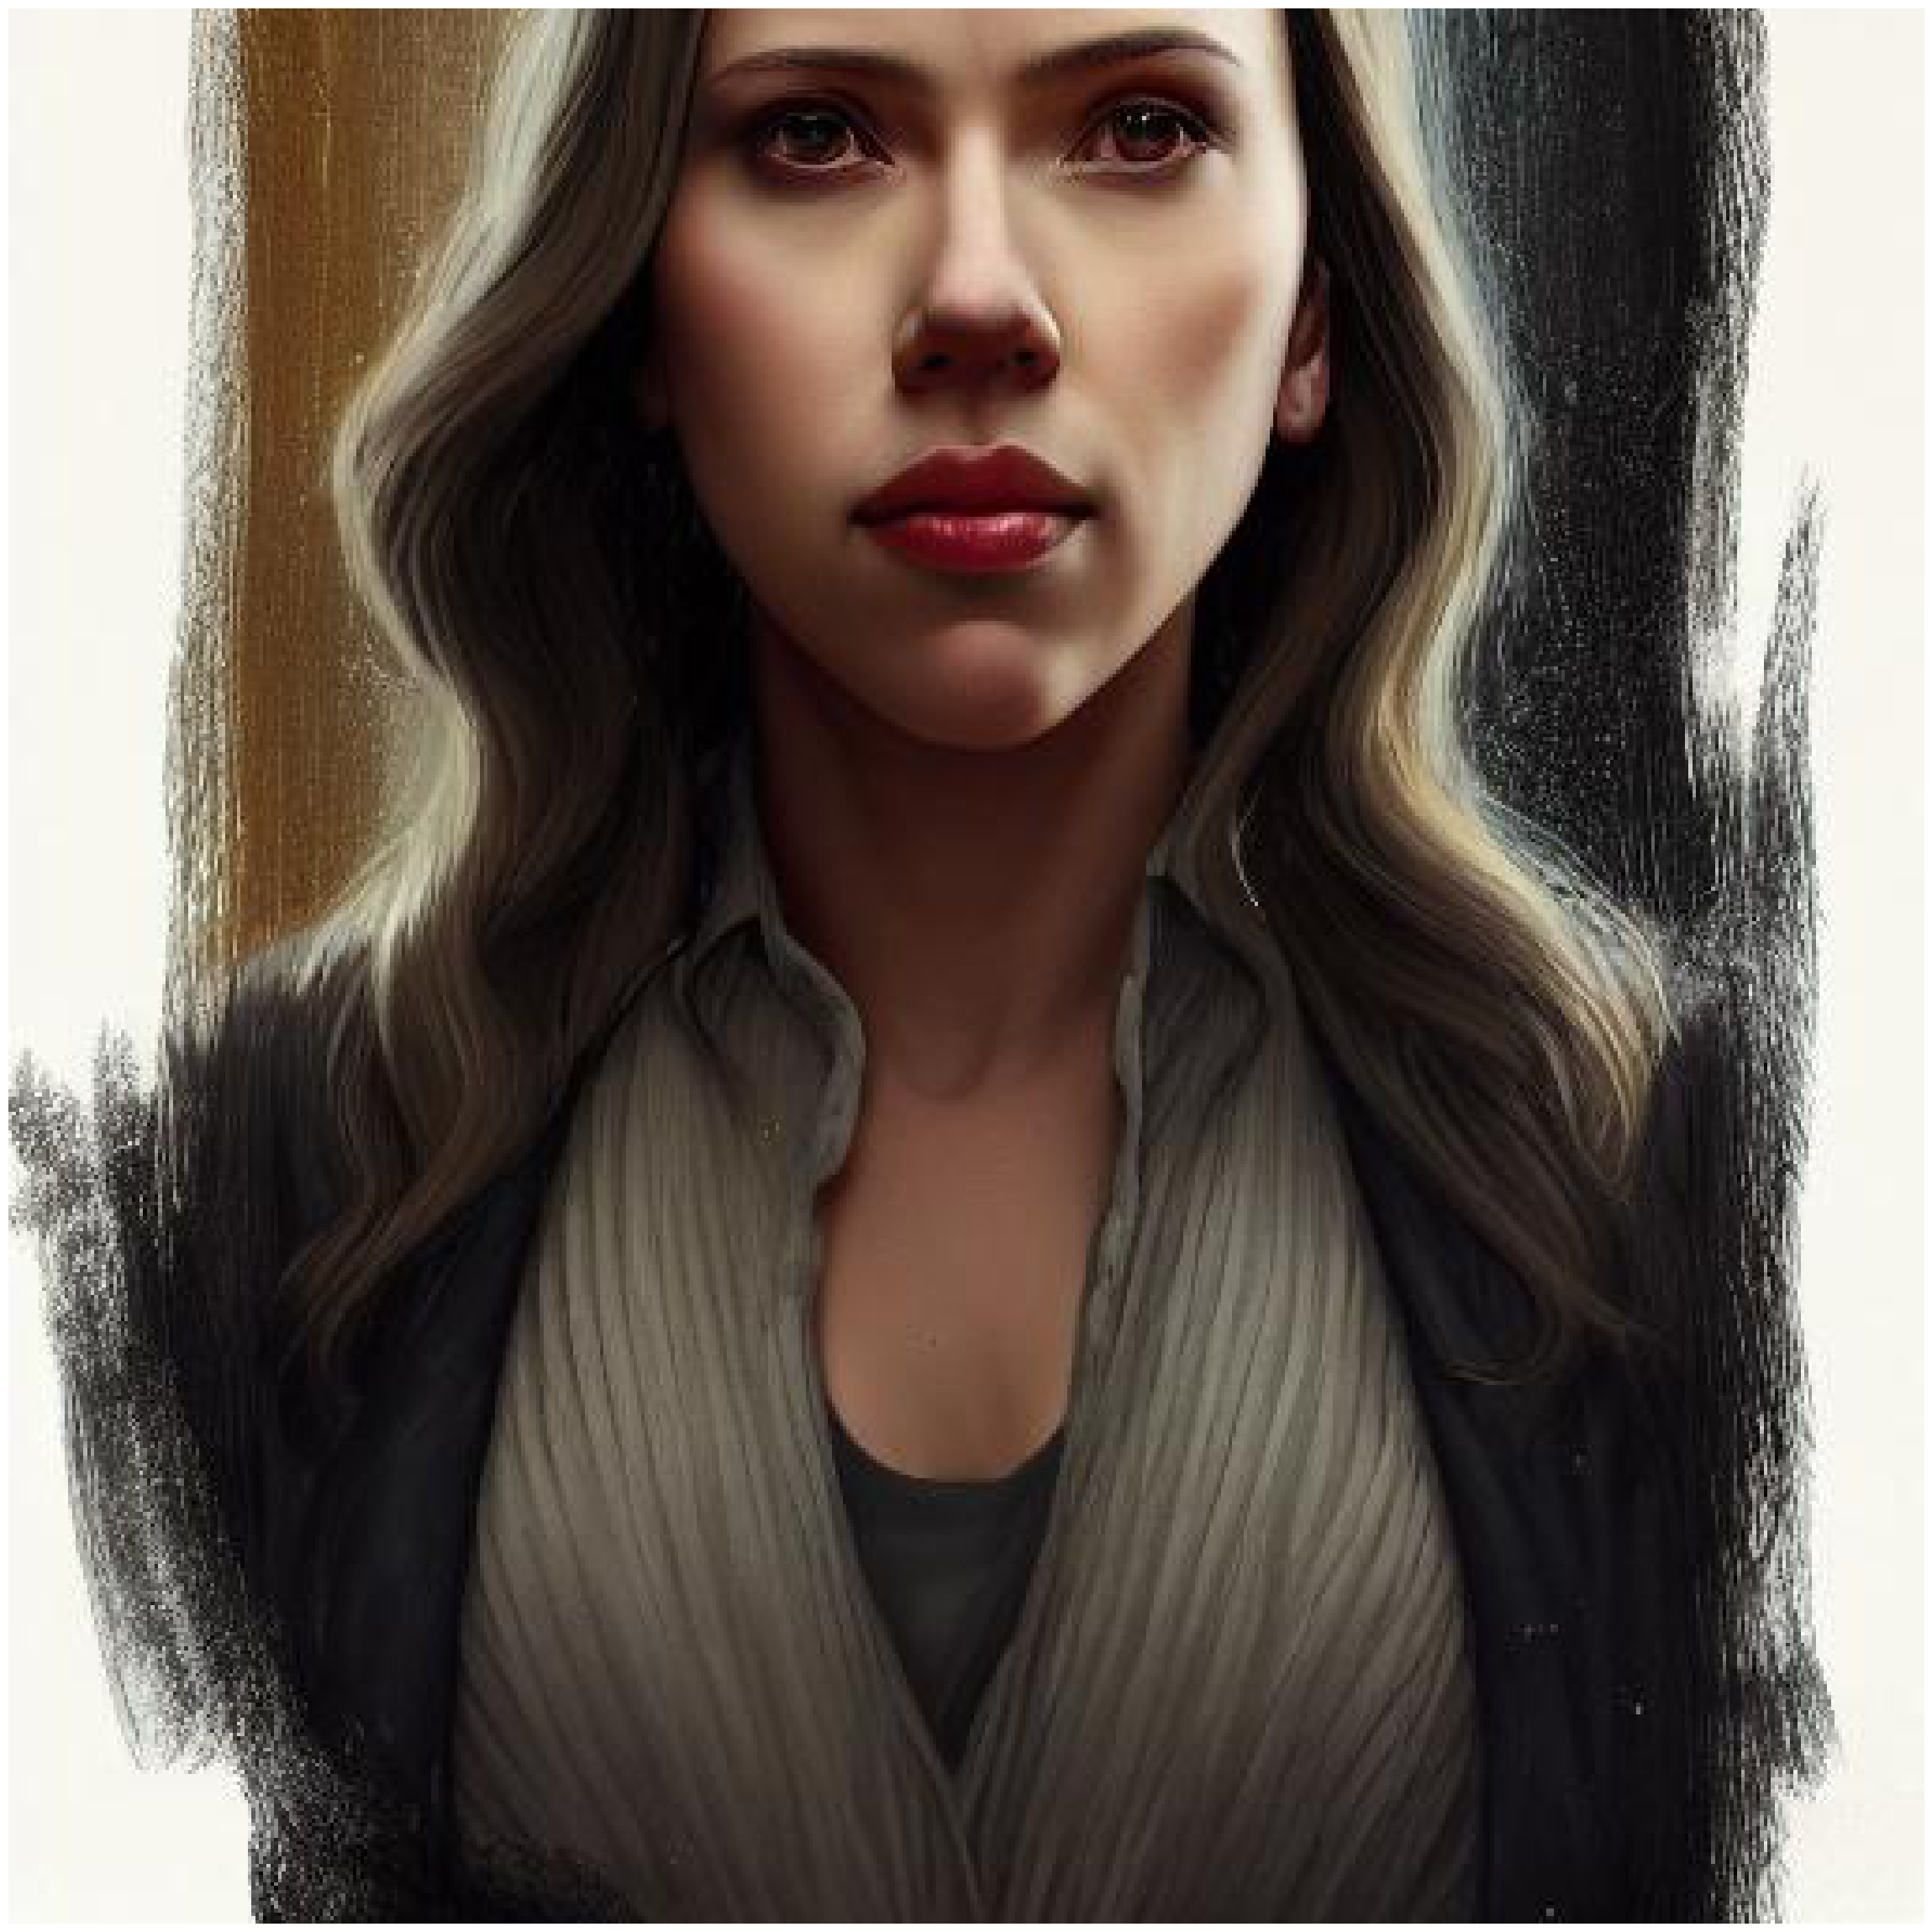

In [8]:
display_images(images)
print(f"Prompt: {response['prompt']}")

When you're done using it, be sure to delete the **SageMaker Endpoint** to avoid unnecessary costs.

In [9]:
_ = sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
_ = sm_client.delete_endpoint(EndpointName=endpoint_name)